In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy
import statsmodels.api as s
from sklearn import metrics

import pdb

In [17]:
sub_list = ['AC_newepoch','AM', 'BB','CM','CR','GG','HA','IB','JM','JR','KK','KT','MC','MH','NF','SB','SG','SOG','TL','ZZ']
data_dir = f'/lab_data/behrmannlab/vlad/pepdoc/results_ex1' #read in the file; first value is the file name
curr_dir = f'/user_data/vayzenbe/GitHub_Repos/pepdoc' #CHANGE AS NEEEDED CAUSE ITS FOR VLAAAD
fig_dir = f'{curr_dir}/figures' #where to save the figures
results_dir = f'{curr_dir}/results' #where to save the results

# bin_size = 1 
categories = ['tool','nontool','bird','insect']
labels = np.asanyarray([0]*5 + [1]*5 + [2]*5 + [3]*5) #creates labels for data

#channels
channels = {'left_dorsal': [77, 78, 79, 80, 86, 87, 88, 89, 98, 99, 100, 110, 109, 118],
            'right_dorsal': [131, 143, 154, 163, 130, 142, 153, 162, 129, 141, 152, 128, 140, 127],
            'dorsal':  [77, 78, 79, 80, 86, 87, 88, 89, 98, 99, 100, 109, 110, 118] + [131, 143, 154, 163, 130, 142, 153, 162, 129, 141, 152, 128, 140, 127],
            'left_ventral':[104, 105, 106, 111, 112, 113, 114, 115, 120, 121, 122, 123, 133, 134],
            'right_ventral':[169, 177, 189, 159, 168, 176, 18, 199, 158, 167, 175, 187, 166, 174],
            'ventral': [104, 105, 106, 111, 112, 113, 114, 115, 120, 121, 122, 123, 133, 134] + [169, 177, 189, 159, 168, 176, 188, 199, 158, 167, 175, 187, 166, 174],
            'frontal': [11, 12, 18, 19, 20, 21, 25, 26, 27, 32, 33, 34, 37, 38],
            'occipital': [145,146,135,136,137,124,125,138,149,157,156,165]}



pre_stim = 50 #ms before stim onset
stim_end = 300 #ms when stim goes off
post_stim = 500 #ms after stim offset
bin_length = 4 #length of each bin in ms
bin_size = 1 #how many bins were averaged over; 1 = no averaging; 5 = average over 20 ms

#calculate start window for analysis given the bin size and length
start_window = pre_stim - (bin_length*(bin_size-1)) 
#calculate the onset point of the stimulus in the dataframe given the start window and bin length
stim_onset = int(start_window/bin_length)+1 
stim_offset = int(stim_end/bin_length)+stim_onset-1
timepoints = list(range(-start_window, post_stim, bin_length)) #134 4 ms bins


#### Measure SNR

In [50]:
rois = ['dorsal','ventral','frontal','occipital']

snr_trial_summary = pd.DataFrame(columns = ['sub']+ rois)
snr_first_summary = pd.DataFrame(columns = ['sub']+ rois)

#loop through subs
for sub in sub_list:
    snr_vals = []
    snr_vals.append(sub)
    snr_first_vals = []
    snr_first_vals.append(sub)
    for roi in rois:
        #load sub data
        #data are formatted stim x time x channels
        sub_data = np.load(f'{data_dir}/{sub}/{roi}_data.npy')

        #calculate mean during stim period
        mean_stim = np.mean(sub_data[:,stim_onset:stim_offset,:], axis = 1)

        #Calculate mean during first 100 ms of sitm period
        first_window = np.mean(sub_data[:,stim_onset:stim_onset+20,:], axis = 1)

        
        #calculate SD during baseline period
        sd_baseline = np.std(sub_data[:,:stim_onset,:], axis = 1)

        #calculate SNR for whole trial
        snr_trial = mean_stim/sd_baseline

        #calculate SNR for first 100 ms of trial
        snr_first = first_window/sd_baseline

        #calculate global mean
        global_trial_mean = np.abs(np.mean(snr_trial))
        global_first_mean = np.abs(np.mean(snr_first))

        snr_vals.append(global_trial_mean)
        snr_first_vals.append(global_first_mean)


    #concat snr values to snr_summary
    snr_trial_summary = pd.concat([snr_trial_summary,pd.DataFrame([snr_vals], columns = snr_trial_summary.columns, index = None)])
    snr_first_summary = pd.concat([snr_first_summary,pd.DataFrame([snr_first_vals], columns = snr_first_summary.columns, index = None)])

#save snr summary
snr_trial_summary.to_csv(f'{results_dir}/snr_trial_summary.csv', index = False)
snr_first_summary.to_csv(f'{results_dir}/snr_first_summary.csv', index = False)
    

    

In [53]:
snr_trial_summary[rois].mean()

dorsal       4.853303
ventral      5.594454
frontal      6.044719
occipital    5.197951
dtype: float64

#### Examine whether dorsal ventral channels split

In [5]:
channel_mat = np.load(f'{results_dir}/channel_similarity.npy')

In [7]:
channel_mat.shape

(256, 256)

In [18]:
cois = [77, 78, 79, 80, 86, 87, 88, 89, 98, 99, 100, 110, 109, 118] + [131, 143, 154, 163, 130, 142, 153, 162, 129, 141, 152, 128, 140, 127] + \
           [104, 105, 106, 111, 112, 113, 114, 115, 120, 121, 122, 123, 133, 134] + [169, 177, 189, 159, 168, 176, 188, 199, 158, 167, 175, 187, 166, 174]
rois = ['dorsal','ventral','frontal','occipital']
cois = []
for roi in rois:
    cois = cois + channels[roi]

channel_mat = np.load(f'{results_dir}/channel_similarity.npy')

channel_df = pd.DataFrame(channel_mat, columns = np.arange(1,257), index = np.arange(1,257))

channel_df = channel_df.loc[cois,cois]



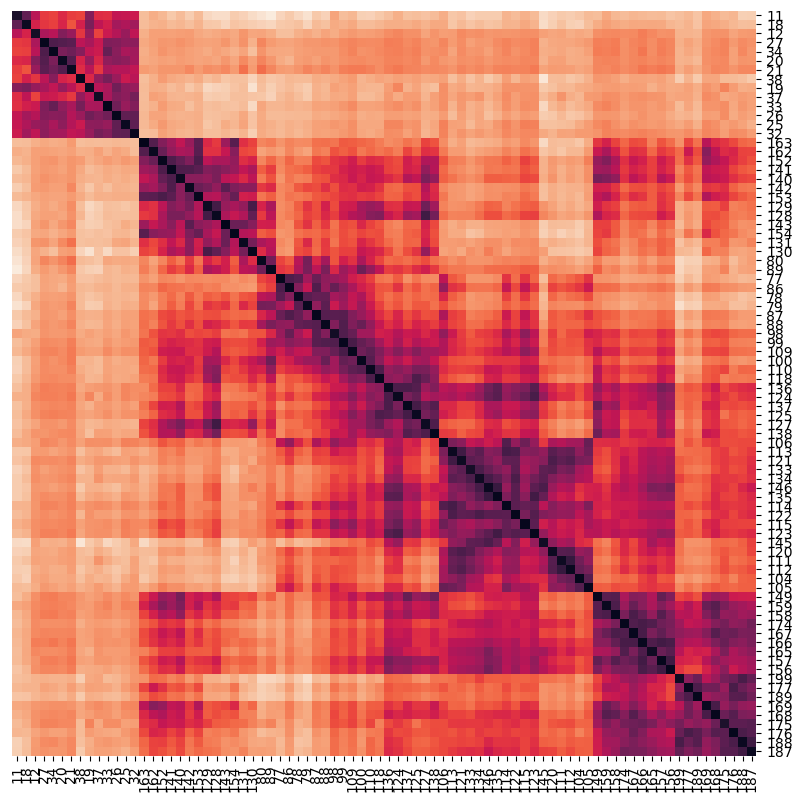

In [19]:
fig = sns.clustermap(channel_df,xticklabels = True, yticklabels = True)
fig.ax_col_dendrogram.set_visible(False)
fig.ax_row_dendrogram.set_visible(False)
fig.ax_cbar.set_visible(False)



plt.savefig(f'{fig_dir}/dv_channel_similarity.png', dpi = 300, bbox_inches = 'tight')

#### Count channels

In [9]:
"""Count how many channels are missing on average"""

channel_perc = []
for sub in sub_list:
    for category in categories[0:1]: #loop through categories
        
        
        curr_df = pd.read_csv(f'/{data_dir}/{sub}/{category}s/{category}{1}.tsv' , sep='\t')#read in the file; first value is the file name
  

        channel_perc.append(1-((curr_df.shape[0]-1)/256))

print('missing channels:',np.mean(channel_perc))

missing channels: 0.1556640625


#### ERP Plots

In [3]:
"""
Calc bootstrap CIs
"""

rois = ['dorsal','ventral']
iter = 10000
alpha = .05

boot_df = pd.DataFrame()
for roi in rois:
    erp_data = np.load(f'{results_dir}/erp/{roi}_mean_ts.npy')

    
    pre_stim = erp_data[:,:stim_onset] #pull out the pre-stimulus data
    pre_stim = np.mean(pre_stim, axis=1) #average across prestim timepoints

    erp_data = erp_data - pre_stim[:,None]#subtract the prestimulus average from each timepoint

    #decoding_data = decoding_data[:,stim_onset:]
    erp_data = pd.DataFrame(erp_data) #convert to dataframe because it has a good resampling function
    erp_boot = []
    

    
    for ii in range(0,iter):
        #resample the sub decode data with replacement
        sub_sample = erp_data.sample(erp_data.shape[0],replace = True, random_state=ii)
        
        #convert it back to a numpy array
        sub_sample = sub_sample.to_numpy() 

        #calculate the bootstrap sample mean
        erp_boot.append(np.mean(sub_sample, axis = 0))

    erp_boot = np.asanyarray(erp_boot)
    erp_cis = np.zeros((3,erp_boot.shape[1]))
    for time in range(0,erp_boot.shape[1]):
        #plot the difference values with confidence intervals
        
        ci_low = np.percentile(erp_boot[:,time], (alpha)*100)
        ci_high= np.percentile(erp_boot[:,time], 100-(alpha)*100)
        if ci_low >= 0:
            sig = 1
        else:
            sig = 0

        erp_cis[0,time] = ci_low
        erp_cis[1,time] = ci_high
        erp_cis[2,time] = sig

    onset_num = np.where(erp_cis[2,:] == 1)[0][0]
    onset = (onset_num *bin_length)-start_window
    print(roi, onset)

    np.save(f'{results_dir}/erp/{roi}_erp_cis.npy',erp_cis)
        


        

dorsal -50
ventral 34


(0, 'dorsal') max time: 230
(1, 'ventral') max time: 254


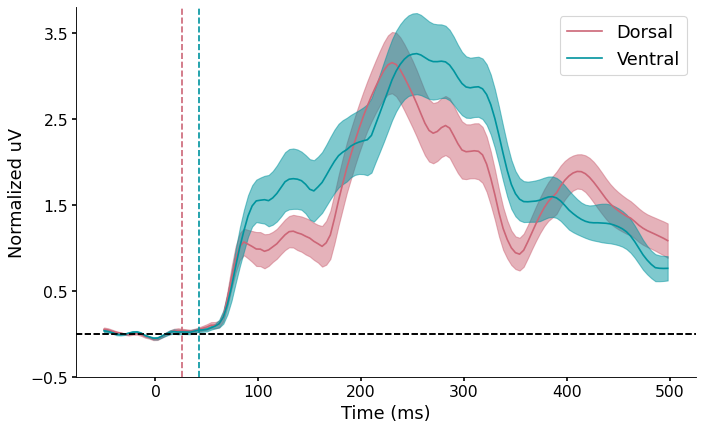

In [4]:
'''
Plot ERPs for each ROI with shading
'''
rois = ['ventral', 'dorsal']
roi_names = ['Ventral', 'Dorsal']
colors = ['#CC6677','#00949e']

rois = ['dorsal', 'ventral']
roi_names = ['Dorsal','Ventral']
#colors = ['#00949e','#CC6677']
onsets = [26,42]

plt.figure(figsize=(10, 6), dpi=80)
for roi in enumerate(rois):
    roi_erp = np.abs(np.load(f'{results_dir}/erp/{roi[1]}_mean_ts.npy'))

        
    pre_stim = roi_erp[:,:stim_onset] #pull out the pre-stimulus data
    pre_stim = np.mean(pre_stim, axis=1) #average across prestim timepoints

    roi_norm = roi_erp - pre_stim[:,None]#subtract the prestimulus average from each timepoint
    
    roi_mean = np.mean(roi_norm, axis=0)
    maxtime = np.where(roi_mean == np.max(roi_mean))[0][0]
    print(f'{roi} max time:', ((maxtime *bin_length)-start_window))
    
    
    sem = np.std(roi_norm, ddof=1, axis =0) / np.sqrt(roi_norm.shape[0])

    plt.plot(timepoints, roi_mean, label=roi[1].capitalize(), color = colors[roi[0]]) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
    plt.axhline(y=0, color='k', linestyle='--')
    
    plt.axvline(x=onsets[roi[0]], color=colors[roi[0]], linestyle='--')
    plt.fill_between(timepoints, roi_mean-sem, roi_mean+sem,alpha=0.5, color = colors[roi[0]])
    plt.legend(fontsize=16)

    plt.xlabel('Time (ms)',fontsize=16)
    plt.ylabel('Normalized uV',fontsize=16)
    
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    plt.ylim(-.5,3.8)

    ax = plt.gca()
    ax.xaxis.set_tick_params(width=1.5)
    ax.yaxis.set_tick_params(width=1.5)

    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, 1))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #plt.show()
    
    plt.savefig(f'{fig_dir}/erp_plot.png', dpi=300)


In [5]:

rois = ['dorsal','ventral']
for roi in rois:
    roi_erp = np.abs(np.load(f'{results_dir}/erp/{roi}_mean_ts.npy'))

        
    pre_stim = roi_erp[:,:stim_onset] #pull out the pre-stimulus data
    pre_stim = np.mean(pre_stim, axis=1) #average across prestim timepoints

    roi_norm = roi_erp - pre_stim[:,None]#subtract the prestimulus average from each timepoint
    
    sig_ts = []
    for time in range(0, roi_norm.shape[1]):
        p_val = stats.ttest_1samp((roi_norm[:,time]), 0, axis = 0, alternative='greater')
        sig_ts.append(p_val[1])

    np.save(f'{results_dir}/erp/{roi}_sig_ts.npy', sig_ts)

(0, 'dorsal') 26
(1, 'ventral') 42


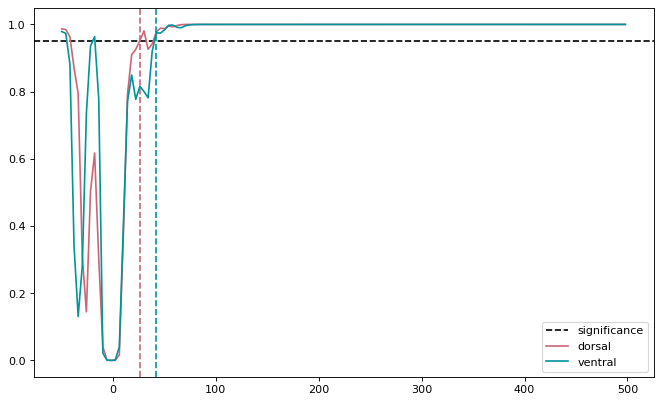

In [6]:
'''
Plot significance time series
'''

rois = ['dorsal','ventral']
line_color =  ['#CC6677','#00949e']
alpha_level = .95
plt.figure(figsize=(10, 6), dpi=80)
plt.axhline(alpha_level, color = 'k', label='significance', linestyle='--')
for roi in enumerate(rois):
    sig_data = 1-np.load(f'{results_dir}/erp/{roi[1]}_sig_ts.npy')
    onset = np.min(np.where(sig_data[stim_onset:] >= alpha_level))+stim_onset
    onset = ((onset *bin_length)-start_window)
    plt.plot(timepoints, sig_data, label = roi[1], color = line_color[roi[0]])
    plt.axvline(onset,  linestyle='--', color = line_color[roi[0]])
    plt.legend()
    print(roi, onset)





#### Test ERP onset

In [7]:
'''
Boot strap participant data and extract onset
'''

rois = ['dorsal','ventral']
iter = 1000

boot_df = pd.DataFrame()
for roi in rois:
    roi_erp = np.abs(np.load(f'{results_dir}/erp/{roi}_mean_ts.npy'))
    pre_stim = roi_erp[:,:stim_onset] #pull out the pre-stimulus data
    pre_stim = np.mean(pre_stim, axis=1) #average across prestim timepoints

    roi_norm = roi_erp - pre_stim[:,None]#subtract the prestimulus average from each timepoint
    
    roi_norm = roi_norm[:,stim_onset:]
    erp_data = pd.DataFrame(roi_norm) #convert to dataframe because it has a good resampling function
    erp_boot = []
    sub_counts = np.zeros((1,erp_data.shape[1]))

    for ii in range(0,iter):
        
        #resample the sub decode data with replacement
        sub_sample = erp_data.sample(erp_data.shape[0],replace = True, random_state=ii)
        
        #convert it back to a numpy array
        sub_sample = sub_sample.to_numpy() 
        
        #calculate the bootstrap sample mean
        sig_boot = []
        
        #only add values if they are significant two timepoints in arow
        sig_consistent = []
        
        sig_ts = []
        for time in range(0,sub_sample.shape[1]):
            p_val= stats.ttest_1samp(sub_sample[:,time], 0, axis = 0, alternative='greater')
            
            #append the p-value for every time point
            sig_ts.append(p_val[1])  


            #mark timepoints that are above chance for at least two timepoints in a row
            if time > 0:

                if sig_ts[time] <= .05 and sig_ts[time-1] <=.05:
                    sig_consistent.append(1)
                else:
                    sig_consistent.append(0)

        #reconvert p-value list into a numpy array
        sig_ts = np.asanyarray(sig_ts)

        #reconvert consistent list into a numpy array
        sig_consistent = np.asanyarray(sig_consistent)
            
        #find the the first time point that is below change (0.05)
        #np.where simply returns the indices (i.e., spots in an array), that meet some condition
        #i'm simply grabbing the first value of that list, which corresponds to the first time point above chance
        try:
            sig_onset = np.where(sig_consistent ==1,)[0][0]
        except:
            sig_onset= erp_data.shape[1]
        
        
        
        sub_counts[0,np.where(sig_ts <=.05)[0]] += 1
        
        #if d_onset == 1:
        #    pdb.set_trace()
        
        #convert to the actual time point
        sig_onset = (sig_onset *4)

        #add the onset value from the resample to a list
        erp_boot.append(sig_onset)
    
    boot_df[roi] = erp_boot

boot_df.to_csv(f'{results_dir}/erp/onset_boot_df.csv',index = False)




In [10]:
'''
Run binomial test on bootstrapped data
'''

comparisons = [['dorsal','ventral'] ]

for roi in comparisons:
    #Calcualte the time  difference for each bootstrap between roi pairs
    diff = boot_df[roi[0]] - boot_df[roi[1]]

    #count the number of times the first roi precedes the other
    time_count = np.sum(diff < 0)

    print('p val', stats.binom_test(time_count,n=len(diff), p= 0.5, alternative='two-sided'))
    print('count of diffs', time_count)
    print('mean diff', np.mean(diff))

p val 1.377828645813839e-09
count of diffs 596
mean diff -10.472


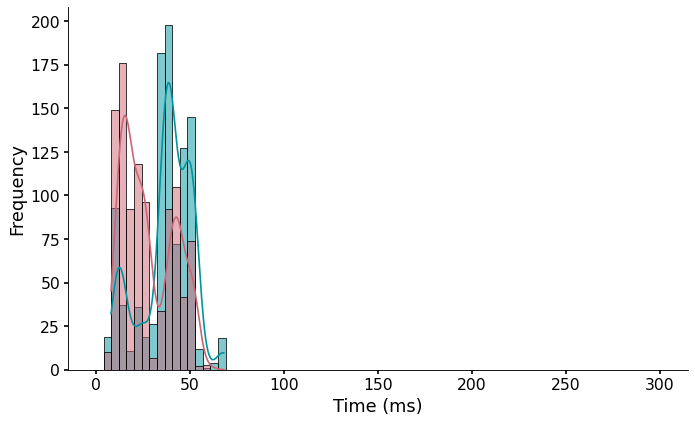

In [8]:



boot_df = pd.read_csv(f'{results_dir}/erp/onset_boot_df.csv')
melt_boot = boot_df.melt(var_name='roi', value_name='onset')
melt_boot['roi'] = melt_boot['roi'].replace({'dorsal':'Dorsal','ventral':'Ventral'})

colors = ['#00949e','#CC6677']
colors = ['#CC6677','#00949e']
plt.figure(figsize=(10, 6), dpi=80)
sns.histplot(data=melt_boot, x = 'onset', binrange = [0,300], bins= 74,hue='roi', legend = False, palette=colors,kde = True, alpha = .5)


#sns.move_legend(ax, "upper right",fontsize=16)
ax.set(
    xlim=(-30, 300),
    
)
#ax.set_xticklabels(fontsize=14)
#ax.set_yticklabels(fontsize=14)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#ax.set_axis_labels(fontsize=16)
#ax.set_xlabels("Time (ms)",fontsize=16)
#ax.set_ylabels("Frequency",fontsize=16)


plt.xlabel('Time (ms)',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#plt.ylim(-.5,3.8)

ax = plt.gca()
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.ax.tick_params(width=1.5)


plt.savefig(f'{fig_dir}/erp_onset_histogram.png', dpi=300)


#### Main decoding plots

In [7]:
"""
Calc bootstrap CIs
"""

rois = ['dorsal','ventral','occipital','frontal']

iter = 10000
alpha = .05

boot_df = pd.DataFrame()
for roi in rois:
    decoding_data = np.load(f'{results_dir}/decode/{roi}_decoding.npy')
    #decoding_data = decoding_data[:,stim_onset:]
    decoding_data = pd.DataFrame(decoding_data) #convert to dataframe because it has a good resampling function
    decode_boot = []
    

    
    for ii in range(0,iter):
        #resample the sub decode data with replacement
        sub_sample = decoding_data.sample(decoding_data.shape[0],replace = True, random_state=ii)
        
        #convert it back to a numpy array
        sub_sample = sub_sample.to_numpy() 

        #calculate the bootstrap sample mean
        decode_boot.append(np.mean(sub_sample, axis = 0))

    decode_boot = np.asanyarray(decode_boot)
    decode_cis = np.zeros((3,decode_boot.shape[1]))
    for time in range(0,decode_boot.shape[1]):
        #plot the difference values with confidence intervals
        
        ci_low = np.percentile(decode_boot[:,time], (alpha)*100)
        ci_high= np.percentile(decode_boot[:,time], 100-(alpha)*100)
        if ci_low >= .25:
            sig = 1
        else:
            sig = 0

        decode_cis[0,time] = ci_low
        decode_cis[1,time] = ci_high
        decode_cis[2,time] = sig

    onset_num = np.where(decode_cis[2,:] == 1)[0][0]
    onset = (onset_num *bin_length)-start_window
    print(roi, onset)

    np.save(f'{results_dir}/decode/{roi}_decode_cis.npy',decode_cis)
        


        

dorsal 66
ventral 98
occipital 66
frontal 66


(0, 'dorsal') max time: 206
(1, 'ventral') max time: 238
(2, 'occipital') max time: 214


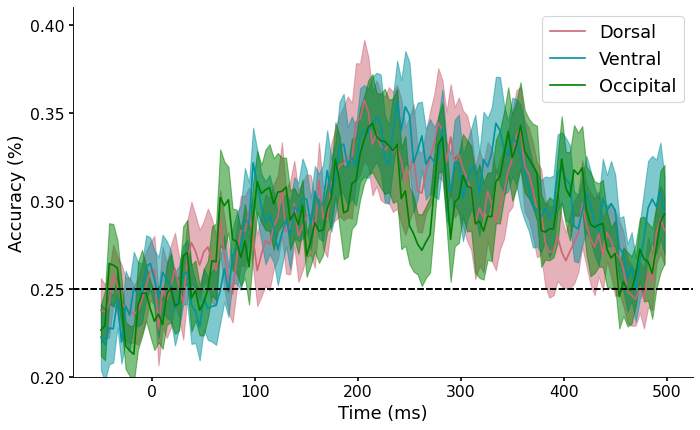

In [8]:
'''
Plot decodeing accuracy for each ROI with shading
'''


colors = ['#CC6677','#00949e','green']

rois = ['dorsal', 'ventral','occipital']
#colors = ['#00949e','#CC6677']
onsets = [66,82]



plt.figure(figsize=(10, 6), dpi=80)
for roi in enumerate(rois):
    roi_decoding = np.load(f'{results_dir}/decode/{roi[1]}_decoding.npy')
    roi_cis = np.load(f'{results_dir}/decode/{roi[1]}_decode_cis.npy')
    roi_mean = np.mean(roi_decoding, axis=0)
    maxtime = np.where(roi_mean == np.max(roi_mean))[0][0]
    print(f'{roi} max time:', ((maxtime *bin_length)-start_window))
    
    sem = np.std(roi_decoding, ddof=1, axis =0) / np.sqrt(roi_decoding.shape[0])

    plt.plot(timepoints, roi_mean, label=roi[1].capitalize(), color = colors[roi[0]]) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
    plt.axhline(y=0.25, color='k', linestyle='--')
    
    #plt.axhline(y=0.2215, color='k', linestyle='--')
    plt.fill_between(timepoints, roi_mean-sem, roi_mean+sem,alpha=0.5, color = colors[roi[0]])
    plt.legend(fontsize=16)

    plt.xlabel('Time (ms)',fontsize=16)
    plt.ylabel('Accuracy (%)',fontsize=16)
    #plt.axvline(onsets[roi[0]],  linestyle='--', color = colors[roi[0]])
    #plt.yticks(np.arange(min(x), max(x)+1, 1.0))
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    plt.ylim(.2,.41)

    ax = plt.gca()
    ax.xaxis.set_tick_params(width=1.5)
    ax.yaxis.set_tick_params(width=1.5)

    start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(start, end, .05))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    #plt.show()
    
    plt.savefig(f'{fig_dir}/decoding_plot.png', dpi=300)


#### Decoding significance across time

In [7]:

rois = ['dorsal','ventral']
for roi in rois:
    decoding_data = np.load(f'{results_dir}/decode/{roi}_decoding.npy')
    sig_ts = []
    for time in range(0, decoding_data.shape[1]):
        p_val = stats.ttest_1samp((decoding_data[:,time]), .25, axis = 0, alternative='greater')
        sig_ts.append(p_val[1])

    np.save(f'{results_dir}/decode/{roi}_sig_ts.npy', sig_ts)

(0, 'dorsal') 66
(1, 'ventral') 98


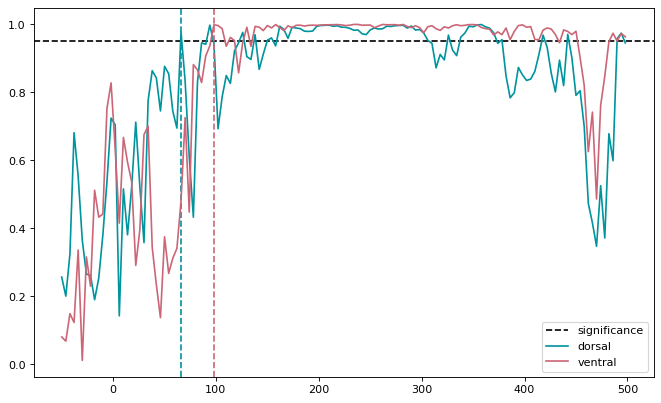

In [8]:
'''
Plot significance time series
'''

rois = ['dorsal','ventral']
line_color = ['#00949e','#CC6677']
alpha_level = .95
plt.figure(figsize=(10, 6), dpi=80)
plt.axhline(alpha_level, color = 'k', label='significance', linestyle='--')
for roi in enumerate(rois):
    sig_data = 1-np.load(f'{results_dir}/decode/{roi[1]}_sig_ts.npy')
    onset = np.min(np.where(sig_data >= alpha_level))
    onset = (onset *bin_length)-start_window
    plt.plot(timepoints, sig_data, label = roi[1], color = line_color[roi[0]])
    plt.axvline(onset,  linestyle='--', color = line_color[roi[0]])
    plt.legend()
    print(roi, onset)





#### Test significant decoding onset

In [9]:
'''
Boot strap participant data and extract onset
'''

rois = ['dorsal','ventral','occipital','frontal']
iter = 1000

boot_df = pd.DataFrame()
for roi in rois:
    decoding_data = np.load(f'{results_dir}/decode/{roi}_decoding.npy')
    decoding_data = decoding_data[:,stim_onset:]
    decoding_data = pd.DataFrame(decoding_data) #convert to dataframe because it has a good resampling function
    decode_boot = []
    sub_counts = np.zeros((1,decoding_data.shape[1]))

    for ii in range(0,iter):
        
        #resample the sub decode data with replacement
        sub_sample = decoding_data.sample(decoding_data.shape[0],replace = True, random_state=ii)
        
        #convert it back to a numpy array
        sub_sample = sub_sample.to_numpy() 
        
        #calculate the bootstrap sample mean
        sig_boot = []
        
        #only add values if they are significant two timepoints in arow
        sig_consistent = []
        
        sig_ts = []
        for time in range(0,sub_sample.shape[1]):
            p_val= stats.ttest_1samp(sub_sample[:,time], .25, axis = 0, alternative='greater')
            
            #append the p-value for every time point
            sig_ts.append(p_val[1])  


            #mark timepoints that are above chance for at least two timepoints in a row
            if time > 0:

                if sig_ts[time] <= .05 and sig_ts[time-1] <=.05:
                    sig_consistent.append(1)
                else:
                    sig_consistent.append(0)

        #reconvert p-value list into a numpy array
        sig_ts = np.asanyarray(sig_ts)

        #reconvert consistent list into a numpy array
        sig_consistent = np.asanyarray(sig_consistent)
            
        #find the the first time point that is below change (0.05)
        #np.where simply returns the indices (i.e., spots in an array), that meet some condition
        #i'm simply grabbing the first value of that list, which corresponds to the first time point above chance
        try:
            sig_onset = np.where(sig_consistent ==1,)[0][0]
        except:
            sig_onset= decoding_data.shape[1]
        
        
        
        sub_counts[0,np.where(sig_ts <=.05)[0]] += 1
        
        #if d_onset == 1:
        #    pdb.set_trace()
        
        #convert to the actual time point
        sig_onset = (sig_onset *4)

        #add the onset value from the resample to a list
        decode_boot.append(sig_onset)
    
    boot_df[roi] = decode_boot

boot_df.to_csv(f'{results_dir}/onsets/onset_boot_df.csv',index= False)

In [17]:
'''
Run binomial test on bootstrapped data
'''

comparisons = [['dorsal','ventral'],['dorsal','occipital'],['ventral','occipital'] ]

for roi in comparisons:
    #Calcualte the time  difference for each bootstrap between roi pairs
    diff = boot_df[roi[0]] - boot_df[roi[1]]

    #count the number of times the first roi precedes the other
    time_count = np.sum(diff < 0)

    print(roi)
    print('p val', stats.binom_test(time_count,n=len(diff), p= 0.5, alternative='two-sided'))
    print('count of diffs', time_count)
    print('mean diff', np.mean(diff))



['dorsal', 'ventral']
p val 3.7085629383308365e-18
count of diffs 637
mean diff -11.044
['dorsal', 'occipital']
p val 0.00021239660353605802
count of diffs 441
mean diff 2.508
['ventral', 'occipital']
p val 5.094504985709548e-36
count of diffs 304
mean diff 13.552


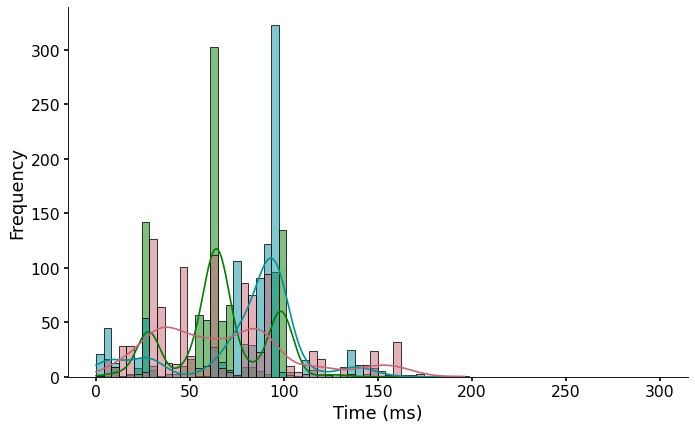

In [16]:
"""Decoding onset histogram"""


boot_df = pd.read_csv(f'{results_dir}/onsets/onset_boot_df.csv')
boot_df = boot_df.drop(columns = ['frontal'])
melt_boot = boot_df.melt(var_name='roi', value_name='onset')
melt_boot['roi'] = melt_boot['roi'].replace({'dorsal':'Dorsal','ventral':'Ventral','occipital':'Occipital'})

colors = ['#00949e','#CC6677']
colors = ['#CC6677','#00949e','green']
plt.figure(figsize=(10, 6), dpi=80)
sns.histplot(data=melt_boot, x = 'onset', binrange = [0,300], bins= 74,hue='roi', legend = False, palette=colors,kde = True, alpha = .5)


#sns.move_legend(ax, "upper right",fontsize=16)
ax.set(
    xlim=(-30, 300),
    
)
#ax.set_xticklabels(fontsize=14)
#ax.set_yticklabels(fontsize=14)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#ax.set_axis_labels(fontsize=16)
#ax.set_xlabels("Time (ms)",fontsize=16)
#ax.set_ylabels("Frequency",fontsize=16)


plt.xlabel('Time (ms)',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#plt.ylim(-.5,3.8)

ax = plt.gca()
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.ax.tick_params(width=1.5)


plt.savefig(f'{fig_dir}/decoding_onset_histogram.png', dpi=300)



#### Control analyses

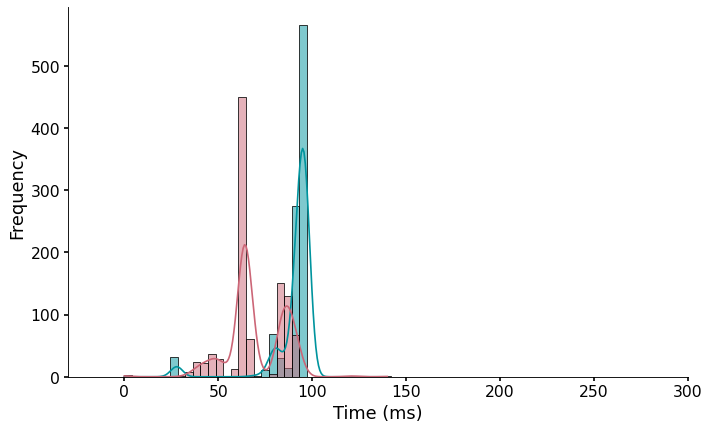

In [8]:
"""
Decoding onset histogram
With channel resample
"""

rois = ['dorsal','ventral','occipital']

boot_df = pd.DataFrame(columns = rois)
for roi in rois:
    #load each rois's boot data
    roi_df = pd.read_csv(f'{results_dir}/onsets/{roi}_channel_resample_boots.csv')

    #add data to a dataframe
    boot_df[roi] = roi_df[roi]


boot_df = boot_df.drop(columns = ['occipital'])
melt_boot = boot_df.melt(var_name='roi', value_name='onset')
melt_boot['roi'] = melt_boot['roi'].replace({'dorsal':'Dorsal','ventral':'Ventral'})

colors = ['#00949e','#CC6677']
colors = ['#CC6677','#00949e']
plt.figure(figsize=(10, 6), dpi=80)
ax = sns.histplot(data=melt_boot, x = 'onset', binrange = [0,300], bins= 74,hue='roi', legend = False, palette=colors,kde = True, alpha = .5)


sns.move_legend(ax, "upper right",fontsize=16)
ax.set(
    xlim=(-30, 300),
    
)
#ax.set_xticklabels(fontsize=14)
#ax.set_yticklabels(fontsize=14)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#ax.set_axis_labels(fontsize=16)
#ax.set_xlabels("Time (ms)",fontsize=16)
#ax.set_ylabels("Frequency",fontsize=16)


plt.xlabel('Time (ms)',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
#plt.ylim(-.5,3.8)

ax = plt.gca()
ax.xaxis.set_tick_params(width=1.5)
ax.yaxis.set_tick_params(width=1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.ax.tick_params(width=1.5)


plt.savefig(f'{fig_dir}/decoding_onset_histogram_resampled_channels.png', dpi=300)

nontool_bird_insect
(0, 'dorsal') max time: 278
(1, 'ventral') max time: 182


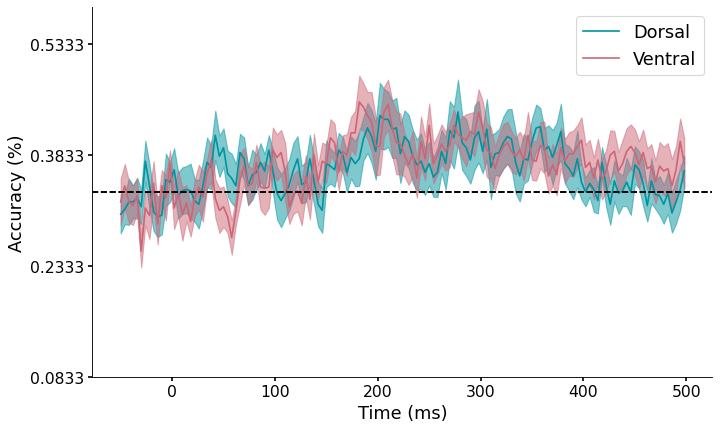

tool_nontool
(0, 'dorsal') max time: 206
(1, 'ventral') max time: 210


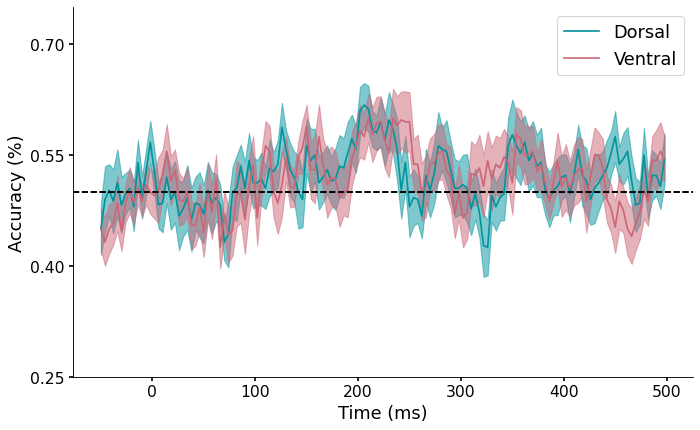

tool_bird
(0, 'dorsal') max time: 306
(1, 'ventral') max time: 242


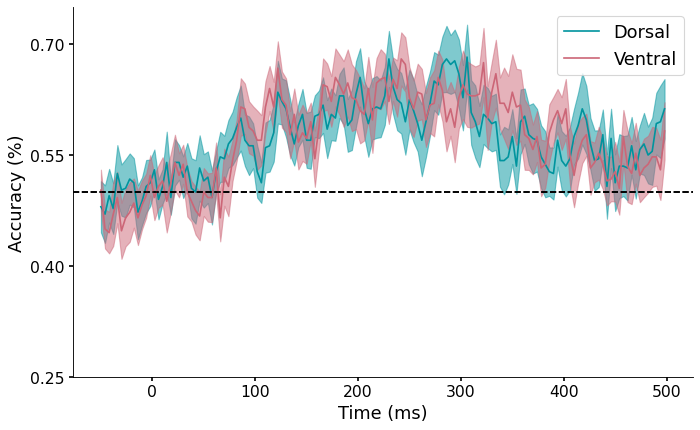

tool_insect
(0, 'dorsal') max time: 250
(1, 'ventral') max time: 258


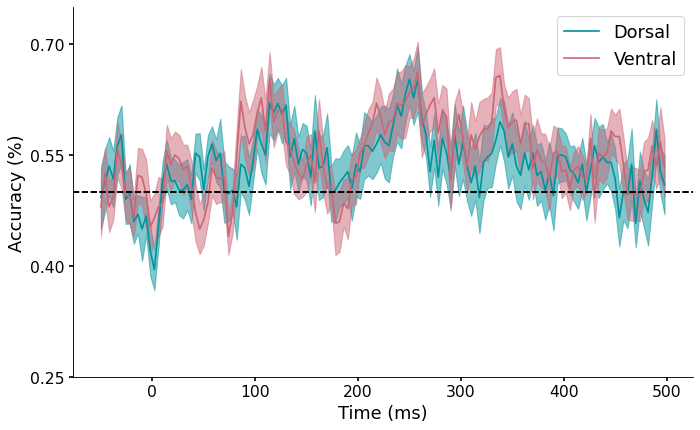

nontool_bird
(0, 'dorsal') max time: 290
(1, 'ventral') max time: 150


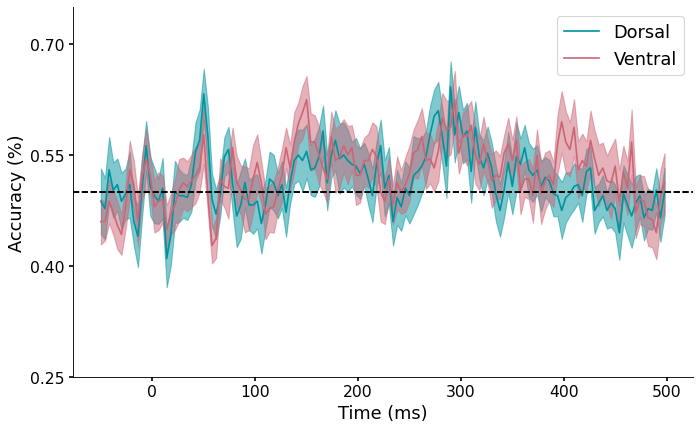

nontool_insect
(0, 'dorsal') max time: 354
(1, 'ventral') max time: 210


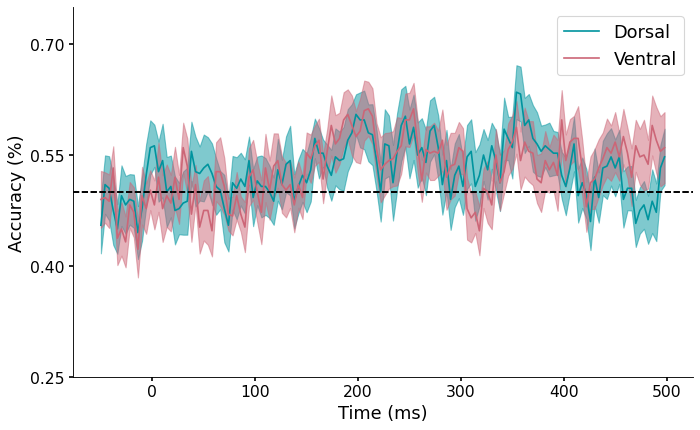

bird_insect
(0, 'dorsal') max time: 218
(1, 'ventral') max time: 190


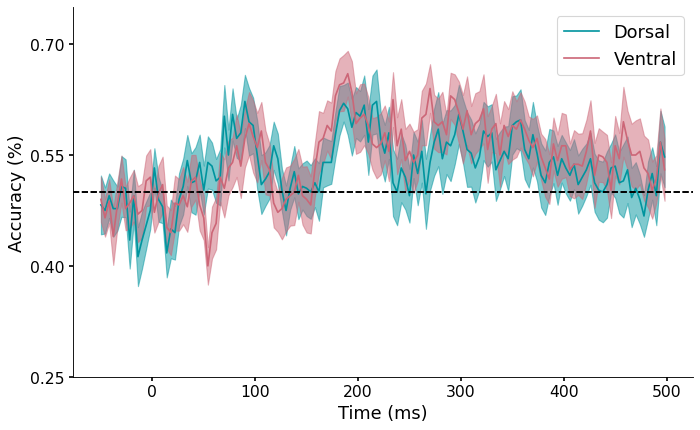

In [16]:
"""
Decoding sig for pairwise comparisons

"""
category_comp = [['nontool','bird','insect']] #initial categories without tools


#append each pairwise category comparison
for cat1 in range(0,len(categories)):
    for cat2 in range(cat1+1,len(categories)):
        category_comp.append([categories[cat1],categories[cat2]])


colors = ['#CC6677','#00949e','green']

rois = ['dorsal', 'ventral']
#colors = ['#00949e','#CC6677']
onsets = [66,82]

alpha_level = .95

for comps in category_comp:
    suf = "_".join(comps)
    print(suf)
        


    plt.figure(figsize=(10, 6), dpi=80)
    for roi in enumerate(rois):
        roi_decoding = np.load(f'{results_dir}/decode/{roi[1]}_decoding_{suf}.npy')
        #roi_cis = np.load(f'{results_dir}/decode/{roi[1]}_decode_cis.npy')
        roi_mean = np.mean(roi_decoding, axis=0)
        maxtime = np.where(roi_mean == np.max(roi_mean))[0][0]
        print(f'{roi} max time:', ((maxtime *bin_length)-start_window))
        
        sem = np.std(roi_decoding, ddof=1, axis =0) / np.sqrt(roi_decoding.shape[0])

        plt.plot(timepoints, roi_mean, label=roi[1].capitalize(), color = colors[roi[0]]) #...plot the data, add error bars to mat plot lib, use standard error of the mean to add., there is a package called psypy to do this (psyplot - SEM)
        plt.axhline(y=1/len(comps), color='k', linestyle='--')
        
        #plt.axhline(y=0.2215, color='k', linestyle='--')
        plt.fill_between(timepoints, roi_mean-sem, roi_mean+sem,alpha=0.5, color = colors[roi[0]])
        plt.legend(fontsize=16)

        plt.xlabel('Time (ms)',fontsize=16)
        plt.ylabel('Accuracy (%)',fontsize=16)
        #plt.axvline(onsets[roi[0]],  linestyle='--', color = colors[roi[0]])
        #plt.yticks(np.arange(min(x), max(x)+1, 1.0))
        plt.xticks(fontsize= 14)
        plt.yticks(fontsize= 14)
        plt.ylim(1/len(comps) -.25,1/len(comps) +.25)

        ax = plt.gca()
        ax.xaxis.set_tick_params(width=1.5)
        ax.yaxis.set_tick_params(width=1.5)

        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start, end, .15))

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    plt.show()
        
        #plt.savefig(f'{fig_dir}/decoding_plot.png', dpi=300)
    plt.close()


In [10]:
sig_data = np.load(f'{results_dir}/decode/{roi[1]}_decoding_sig_{suf}.npy')

In [11]:
f'{results_dir}/decode/{roi[1]}_decoding_sig_{suf}.npy'

'/user_data/vayzenbe/GitHub_Repos/pepdoc/results/decode/dorsal_decoding_sig_nontool_bird_insect.npy'